In [1]:
import os, sys
os.chdir(os.path.abspath('..'))

In [2]:
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.baseline_models import QuantileRegressionNetwork
import src.experiment_lib as experiment_lib
from src.datasets import ContexedDataset
from src.forecasting_metrics import *

In [4]:
config_dir = 'runs/forecast_baseline/'
config_folder = 'tmp_Dec04_17-26-44/'
config = json.load(open(config_dir + config_folder +'config.json', 'r'))
data_config = json.load(open(config_dir + config_folder + 'data_config.json', 'r'))

In [5]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(data_config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=1000
Mean of enrolments: 0.31
Number of Training Points...............1493743
Number of Testing Points................498590
Number of Validation Points.............498455
Number of Missing Points.................2162


In [6]:
inputs, contexts = {}, {}
for set_type in ["test"]:
    inputs[set_type] = np.concatenate([value for key, value in condition_set[set_type].items() if key.endswith("_befores")],axis=1)
    contexts[set_type] = {key: condition_set[set_type][key] for key in condition_set[set_type] if not key.endswith("_befores")}

for tag in conditioner.tags.copy():
    if tag.endswith("_befores"): 
        conditioner.tags.remove(tag)
        conditioner.cond_dim -= 24

In [7]:
num_users = user_ids["train"][-1]+1
num_test_days = int(X_test.shape[0]/num_users)

In [8]:
model = QuantileRegressionNetwork(input_size=inputs["test"].shape[1], 
                                    context_size=conditioner.cond_dim, 
                                    output_size=24, 
                                    num_hidden_layers = config["model"]["num_hidden_layers"],
                                    num_neurons = config["model"]["num_neurons"],
                                    quantiles=config["model"]["quantiles"])


In [9]:
model.load_state_dict(torch.load(config_dir + config_folder + 'trained_model.pt', weights_only=True))
model.eval()

QuantileRegressionNetwork(
  (network): Sequential(
    (0): Linear(in_features=76, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=1500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1500, out_features=1500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1500, out_features=1500, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1500, out_features=1500, bias=True)
    (9): ReLU()
    (10): Linear(in_features=1500, out_features=168, bias=True)
  )
)

In [10]:
torch.cuda.empty_cache()
import gc
gc.collect()

22

In [11]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
pass

In [12]:
log_space = data_config["data"]["scaling"]["log_space"]
zero_id = data_config["data"]["scaling"]["zero_id"]
shift = data_config["data"]["scaling"]["shift"]

quantiles = config["model"]["quantiles"]
num_quantiles = len(quantiles)

In [13]:
batch_size=2**12
quantiles_test = torch.zeros((inputs["test"].shape[0], 24, num_quantiles))

for i in range(inputs["test"].shape[0]//batch_size):
    with torch.no_grad():
        if i*batch_size+batch_size > inputs["test"].shape[0]:
            batch = inputs["test"][i*batch_size:]
            context = conditioner.transform({key: context[i*batch_size:] for key, context in contexts["test"].items()})
        else:
            batch = inputs["test"][i*batch_size:i*batch_size+batch_size]
            context = conditioner.transform({key: context[i*batch_size:i*batch_size+batch_size] for key, context in contexts["test"].items()})
        batch = torch.tensor(batch, dtype=torch.float32).to(device)
        context = torch.tensor(context, dtype=torch.float32).to(device)
        quantiles_test[i*batch_size:i*batch_size+batch_size] = model(batch, context).cpu()
        
quantiles_test = quantiles_test.detach().cpu().numpy().transpose(2, 0, 1)

In [14]:
quantiles_test_denorm = utils.zero_preserved_log_denormalize(quantiles_test, nonzero_mean, nonzero_std, shift=shift, zero_id=zero_id, log_input=log_space)

quantiles_test = quantiles_test.reshape(num_quantiles, num_users, -1)
quantiles_test_denorm = quantiles_test_denorm.reshape(num_quantiles, num_users, -1)

X_test_denorm = utils.zero_preserved_log_denormalize(X_test, nonzero_mean, nonzero_std, shift=shift, zero_id=zero_id, log_input=log_space).reshape(num_users,-1)
X_test = X_test.reshape(num_users,-1)

In [15]:
user_idx = 55
start_day = 30
end_day = 50

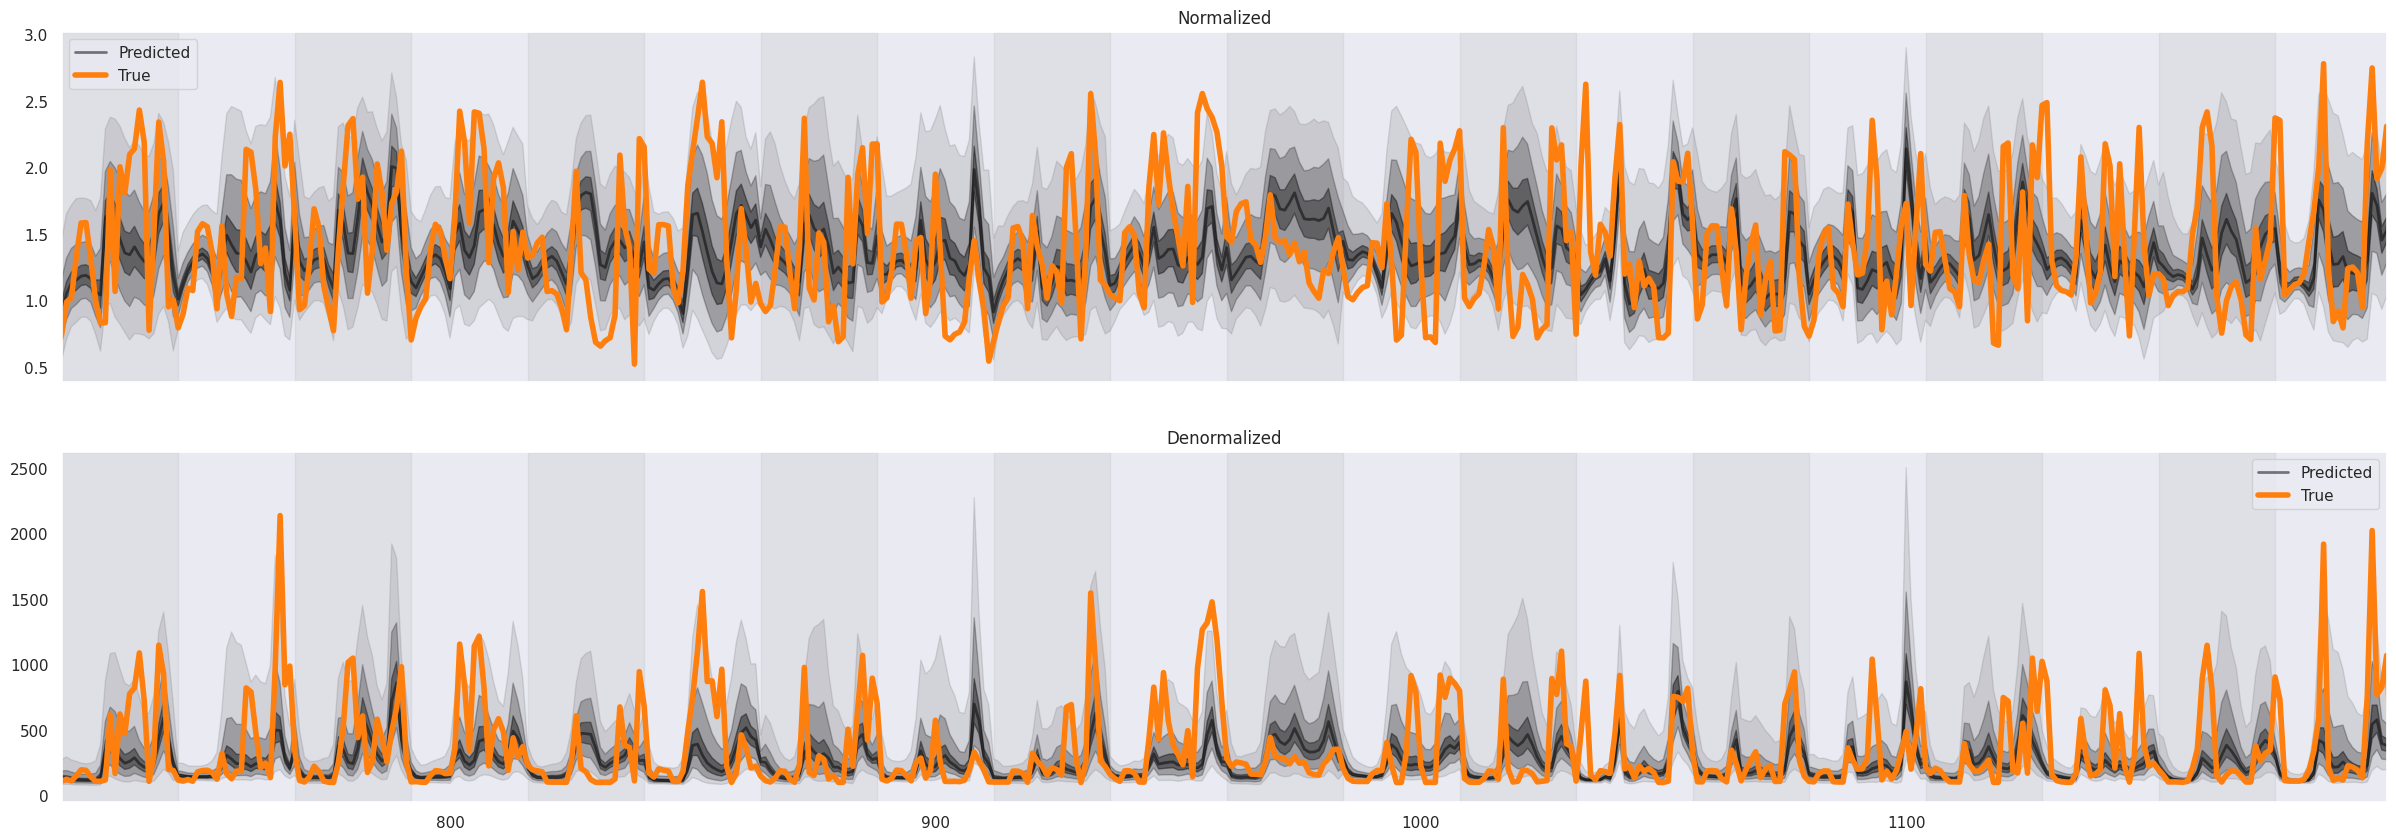

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

for i in range(quantiles.__len__()//2): ax[0].fill_between(np.arange(quantiles_test.shape[-1]), quantiles_test[i,user_idx,:], quantiles_test[-(i+1),user_idx,:], alpha=1*quantiles[i], color="black")
ax[0].plot(quantiles_test[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=2, alpha=0.5)
ax[0].plot(X_test[user_idx], label="True", lw=4, alpha=1.0, color="tab:orange")
# ax[0].plot(np.concatenate((X_test.reshape(num_users,-1)[user_idx][-24:], X_test.reshape(num_users,-1)[user_idx][:-24])), label="True", lw=4, alpha=1.0, color="tab:orange") 
ax[0].set_title("Normalized")

for i in range(quantiles.__len__()//2): ax[1].fill_between(np.arange(quantiles_test_denorm.shape[-1]), quantiles_test_denorm[i,user_idx,:], quantiles_test_denorm[-(i+1),user_idx,:], alpha=1*quantiles[i], color="black")
ax[1].plot(quantiles_test_denorm[quantiles.__len__()//2,user_idx,:], label="Predicted", color="black", lw=2, alpha=0.5)
ax[1].plot(X_test_denorm[user_idx], label="True", lw=4, alpha=1.0, color="tab:orange")
# ax[1].plot(np.concatenate((X_test_denorm[user_idx][-24:], X_test_denorm[user_idx][:-24])), label="True", lw=4, alpha=0.5, color="tab:green") 
# ax[1].plot(np.concatenate((X_test_denorm[user_idx][-24*2:], X_test_denorm[user_idx][:-24*2])), label="True", lw=4, alpha=0.5, color="tab:green") 
# ax[1].plot(np.concatenate((X_test_denorm[user_idx][-24*7:], X_test_denorm[user_idx][:-24*7])), label="True", lw=4, alpha=0.5, color="tab:green") 
ax[1].set_title("Denormalized")

for i in [0,1]:
    ax[i].grid(False)
    #put a gray background every 24 hours
    for j in range(start_day, end_day,2):
        ax[i].axvspan(24*j, 24*(j+1), color="gray", alpha=0.1)

ax[0].legend()
ax[1].legend()
# ax[1].set_yscale("log")

plt.xlim(24*start_day, 24*end_day-1)
plt.show()


In [18]:
quantile_loss, quantile_losses = calculate_quantile_loss(X_test_denorm, quantiles_test_denorm, quantiles)
coverage_score, coverage_scores = calculate_coverage_score(X_test_denorm, quantiles_test_denorm, quantiles)
interval_score, interval_scores, iqrs = calculate_interval_score(X_test_denorm, quantiles_test_denorm, quantiles)
interval_coverage_score, interval_coverage_scores, iqrs = calculate_interval_coverage_score(X_test_denorm, quantiles_test_denorm, quantiles)
mean_absolute_dev, mean_absolute_devs = calculate_mean_absolute_deviation(X_test_denorm, quantiles_test_denorm, quantiles)

In [19]:
results_dict = {"sample_flag": False, "results": {"quantile_loss":quantile_loss, "mean_absolute_dev":mean_absolute_dev, "coverage_score":coverage_score, "interval_score":interval_score, "interval_coverage_score":interval_coverage_score}}

In [20]:
df_results = pd.DataFrame(results_dict["results"], index=[0])

In [21]:
df_results.iloc[0]

quantile_loss               55.102430
mean_absolute_dev          171.903477
coverage_score               0.030532
interval_score             968.494032
interval_coverage_score      0.397208
Name: 0, dtype: float64

In [37]:
#save results as json to config_dir + config_folder with tabs
with open(os.path.join(config_dir, config_folder, f"results_forecasting.json"), 'w') as f:
    json.dump(results_dict, f, indent=4)